## Hyperplane folding.

The following code runs the algorithm from the paper:
*Hyperplane folding - a way to increase the margin in Support Vector Machines
*Lars Lundberg, Håkan Lennerstad, Eva Garcia-Martin, Niklas Lavesson and Veselka Boeva

It does the following:
1. Apply SVM in a dataset
2. Select the primary support vector
3. Divide the points into two, ones to the left of the support vector (forming an orthogonal line with the hyperplane) and the other ones to the right of the support vector
4. Apply two SVM on each new set of points
5. Rotate one side an angle a. 
6. The margin has thus increased from the initial one. 

In [223]:
"""
Simulation functions
"""

def generate_point(center, radius):
    #Generate a random vector on the unit circle (length 1)
    ang = uniform(0, 2*pi)
    v = np.array([cos(ang), sin(ang)])
 
    # Generate a normally distributed length
    #(mean = 0, so the length can be negative)
    l = radius + 1
    while abs(l) > radius:
        l = normalvariate(0, radius)
    return center + l * v


def generate_points(centers, points_per_circle, radius):
    X = list()
    Y = list()
    count = 1
    
    for center in centers:
        for i in range(points_per_circle):
            X.append(generate_point(center, radius))
            if count%2:
                Y.append(0)
            else:
                Y.append(1)
        count += 1
        
    X=np.array(X)
    Y=np.array(Y)
    return (X,Y)

def get_margin(clf):
    w = clf.coef_[0]
    a = -w[0] / w[1]
    s_vectors = clf.support_vectors_
    intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
    intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
    margin = (abs(intrc_up - intrc_down))/(math.sqrt(1+(a*a)))
    return margin

def plot_SVM(clf,x,y, should_plot):
    if should_plot: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        xx = np.linspace(x[:,0].min(),x[:,0].max())
        intercept = -(clf.intercept_[0]) / w[1]
        s_vectors = clf.support_vectors_

        # Margin
        intrc_up = (s_vectors[-1][1] - a * s_vectors[-1][0])
        intrc_down = (s_vectors[0][1] - a * s_vectors[0][0])
        yy = a * xx + intercept
        yy_up = a * xx + intrc_up
        yy_down = a * xx + intrc_down

#         pdf = PdfPages('SVM' + str(time.clock()) + '.pdf')
#         fig=figure(figsize=(6,4))
        
        plt.plot(xx, yy, 'k-')
        plt.plot(xx, yy_down, 'k--')
        plt.plot(xx, yy_up, 'k--')

        plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],s=80, facecolors='none')
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        
#         pdf.savefig(fig) # note the format='pdf' argument!
#         pdf.close()
    
def get_support_vector(X, Y, supp):
    
    s=0
    supp_v=0
    for i in supp:
        s += Y[i]
    for n in supp:
        if Y[n] == 1 and s == 1:
            return X[n]
        if Y[n] == 0 and s== 2:
            return X[n]
        
def point_vs_othline(point, supp,  a ): 
    t= (point[0] - supp[0])/(-a)
    if point[1] <= supp[1] + t:
        return "higher/right"
    else:
        return "lower/left"
    
def split2 (X,Y, clf, prime_sv):
    r"""
    Splitting the points in X and Y, based on an orthogonal line to the hyperplane
    obtained by the classifier clf
    
    return: both sets of points
    """
    set1x=list()
    set2x=list()
    set1y=list()
    set2y=list()
    # In case there are more than 1 point with the same value as the support vector, so that we don't add it twice.
    already_added = False
    
#     for item in clf.n_support_:
#         suppsum+=item
    if len(clf.support_vectors_) == 3: 
        w = clf.coef_[0]
        a = -w[0] / w[1]
        i=0
        for item in X:
            if (item[0]==prime_sv[0]) and (item[1]==prime_sv[1]) and already_added == False:
                set1x.append(item)
                set1y.append(Y[i])
                set2x.append(item)
                set2y.append(Y[i])
                already_added = True
            elif point_vs_othline(item,prime_sv,a ) == "higher/right":
                set2x.append(item)
                set2y.append(Y[i])
            elif point_vs_othline(item,prime_sv,a) == "lower/left":
                set1x.append(item)
                set1y.append(Y[i])
            else:
                print "There is something wrong. Point is not either higher nor lower"
            i+=1
    else:
        raise Exception('More than 3 Support Vectors. N of SV: ', suppsum )
    return [set1x, set1y, set2x, set2y]


def folding_point(clf1, clf2):
    
    w1 = clf1.coef_[0]
    a1 = -w1[0] / w1[1]
    intercept1= -(clf1.intercept_[0]) / w1[1]
    
    w2 = clf2.coef_[0]
    a2 = -w2[0] / w2[1]
    intercept2= -(clf2.intercept_[0]) / w2[1]
    
    xf = (intercept2-intercept1)/(a1-a2)
    yf = xf*a1 + intercept1
    
    angle = np.arctan(a1) - np.arctan(a2)
    return [xf,yf] , angle
    
def remove_supp (sx, sy, supp):
    
    index=0
    while sx[index][0] != supp[0] and sx[index][1] != supp[1]:
        index+=1
    sx = np.delete(sx,index, 0)
    sy = np.delete(sy,index)
    
    return sx,sy
    
def points_folded(X, f_point, angle):
    
    i=0
    XR = np.zeros(X.shape)
    # 1. 2. and 3.
    for item in X:
        XR[i][0] = item[0] - f_point[0] 
        XR[i][1] = item[1] - f_point[1]
        
        x_p = np.cos(angle)*XR[i][0] - np.sin(angle)*XR[i][1]
        y_p = np.sin(angle)*XR[i][0] + np.cos(angle)*XR[i][1]
        
        XR[i][0] = x_p + f_point[0]
        XR[i][1] = y_p + f_point[1]
        i+=1
    return XR

def get_clf():
    """
    Return the classifier, so that we can test different classifiers and not only one
    We don't need to change the instance everywhere, which outputs many errors due to the manual
    change that it requires. 

    """
     
#     C = 1000000000
    return svm.SVC(kernel='linear', C=0.1) 
#     return svm.NuSVC(kernel='linear', nu=0.0000001) 

def folding(x,y,clf, plot = True):
    """
    Gets the main support vector. 
    Divides the dataset into 2,based on the orthogonal line 
    to the plane and the main support vector. 
    Apply SVM on both sides, rotate the one with the greatest margin. 
    """
    prime_sv = get_support_vector(x,y, clf.support_ )
    set1x, set1y, set2x, set2y = split2 (x, y, clf, prime_sv)
    
    
    clf_s1 = get_clf()
    clf_s1.fit(set1x, set1y)
    margin1 = get_margin(clf_s1)
    
    clf_s2 = get_clf()
    clf_s2.fit(set2x, set2y)
    margin2 = get_margin(clf_s2)
    
    
    f_point, angle = folding_point(clf_s1, clf_s2)
    
    print "prime sv: " , prime_sv
    
    if margin1 > margin2: 
        part_folded = "left"
        set1x_nosupp, set1y_nosupp = remove_supp (np.array(set1x), set1y, prime_sv)
        XR = points_folded(set1x_nosupp, f_point, -angle)
        x_folded = np.concatenate((XR, np.array(set2x))) 
        y_folded = np.concatenate ((np.array(set1y_nosupp),np.array(set2y)))
        
        
    else:
        part_folded = "right"
        set2x_nosupp, set2y_nosupp = remove_supp (np.array(set2x), set2y, supp)
        XR = points_folded(set2x_nosupp, f_point, angle)
        x_folded = np.concatenate((np.array(set1x), XR)) 
        y_folded = np.concatenate ((np.array(set1y), np.array(set2y_nosupp)))
        
#         print "X_FOLDED 2: ", x_folded , "\n Y_FOLDED 2: ", y_folded
    
    if plot:
        print "\nSVM Set 1: LEFT"
        plot_SVM(clf_s1, np.array(set1x), set1y,plot)
        print "\nSVM Set 2: RIGHT"
        plot_SVM(clf_s2, np.array(set2x), set2y ,plot)
        
    return angle, part_folded, x_folded, y_folded, prime_sv, f_point

def plot_points(x,y, should_plot):
    if should_plot:
        pdf = PdfPages('points' + str(time.clock()) + '.pdf')
        
        fig=figure(figsize=(6,4))
        plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
        plt.axis('tight')
        plt.show()
        pdf.savefig(fig) # note the format='pdf' argument!
        pdf.close()
        
def remove_extra_sv(clf):
    # We remain with the first three
    # Need to change also dual_coef_ to remove the SVs > 3. 
    # Then coef_ will be changed automatically. 
    if len(clf.support_vectors_) > 3:
        clf.support_vectors_ = clf.support_vectors_[0:3]
        clf.dual_coef_ = clf.dual_coef_[0,0:3]
        clf.dual_coef_ = clf.dual_coef_.reshape((1,-1))
        
    return clf

In [217]:
def load_dataset(filename):
    dataset = pd.read_csv('../../datasets/'+filename)
    return dataset

In [218]:
def project_points(dataset):
    """
    Projecting the points from 3D to 2D, so that they are orthogonal to the Z axis.
    Håkan Lennerstad's formulas
    
    1. Apply SVM on dataset
    2. Get pair of support vectors
    3. Choose the pair with the minumum distance 
    """
    
    X = dataset.iloc[:,:3]
    Y = dataset['class']
    clf = get_clf()
    clf.fit(X, Y)
    
        
    # Calculating distance. Need to check all the SV, check the shortest distance for each pair. 
    d1 = abs(np.linalg.norm(clf.support_vectors_[0]-clf.support_vectors_[1])) 
    d2 = abs(np.linalg.norm(clf.support_vectors_[2]-clf.support_vectors_[3]) )

    v = clf.support_vectors_[0]
    u = clf.support_vectors_[1]
    
    if d1 > d2:
        v = clf.support_vectors_[2]
        u = clf.support_vectors_[3]

        
    print "v: ", v, " u: ", u
    w = v - u
    
    print "w: ", w
    W = np.linalg.norm(w)
    print "W: ", W
    W_12 = np.linalg.norm(w[:2])
    print "W12: ", W_12

    cosTheta = (w[2])/W
    sinTheta = W_12/W

#     R = [[None for y in range(0,3)] for x in range (0,3)]
    R = [[ ((w[2]/W) + (w[1]**2 * (1-(w[2]/W))/W_12**2)) , -w[0]*w[1]*(1-(w[2]/W))/W_12**2, -w[0]/W],
         [-w[0]*w[1] * ((1-(w[2]/W))/W_12**2), w[2]/W + (w[0]**2*(1-(w[2]/W))/W_12**2), -w[1]/W], 
         [w[0]/W , w[1]/W, w[2]/W]]
    
    
    X_projected = pd.DataFrame(columns=X.columns)
    for index, row in X.iterrows():
        newpoint = np.dot(R,row.transpose())
        X_projected.loc[index] = newpoint

        
    print "X initial points: \n\n" , X
    print "\nX Projected points: \n\n" , X_projected
    Z = X_projected.iloc[:,2]
#     print "\nZ component: \n", Z
    X_projected = X_projected.iloc[:,0:2]
    print "\nX Projected points after removing Z : \n\n" , X_projected
    
    return X_projected, Z

In [219]:
# Simulation: Training. 

def training(X_projected, Y, Z, iterations):
    """
    Training SVM on dataset
    """
    # Dictionary that saves the information of every rotation
    folding_info = dict()
    
    # Data
    angle, part_folded, x_folded, y_folded, prime_sv, f_point = None, None, None, None, None, None
    should_plot = True

    d_x = np.array(X_projected)
    d_y = np.array(Y)
    d_z = np.array(Z)

#     for i in range(0,iterations+1): 
    for i in range(0,2): 
        
        # 1. SVM, margin and plot of the initial points. 
        clf = get_clf() 
        clf.fit(d_x, d_y)
        margin = get_margin(clf)
        
        # Remove extra support vectors
        clf = remove_extra_sv(clf)
        
        if i==0:
            print "\nInitial SVM. No folding yet.  Initial Margin: {:f}".format(margin)
            
        plot_SVM(clf,d_x, d_y, should_plot)
        
        # 2. Folding. 
        angle, part_folded, x_folded, y_folded, prime_sv, f_point = folding(d_x, d_y, clf)

        folding_info[str(i)] = {'margin': margin, 'clf': clf, 'angle': angle, 
                           'part':part_folded, 'x_folded': x_folded, 
                           'y_folded': y_folded, 'prime_support_vector': prime_sv,
                           'f_point': f_point}
        
        # 3. SVM on the folded points, to check the margin increase. Plot it
        clf = get_clf() 
        clf.fit(x_folded, y_folded)
        margin = get_margin(clf)
        print "Folding {:d} . Folding the {:s}. Margin: {:f}".format(i+1,part_folded, margin)
        plot_SVM(clf,x_folded, y_folded, should_plot)


        # 4. Add the Z component. Create the dataset with the same format as before
        df_dict = {'f1': x_folded[:,0], 
                   'f2': x_folded[:,1],
                   'f3': d_z,
                   'class': y_folded}
        
        dataset_after_folding = pd.DataFrame(data=df_dict, columns = ['f1', 'f2', 'f3', 'class'])
       
        # 5. Rotate and project the points again. These will be the initial points for the next round.  
        X_projected, Z = project_points(dataset_after_folding)
        
        # Project points again 
        d_x = np.array(X_projected)
        # Y stays the same: y_folded
        d_y = np.array(y_folded)
        d_z = np.array(Z) 

In [220]:
# Simulation: Testing
# Need to do the same rotations that we did for training, and keep track of it. 


def testing(dataset):
    print "Testing: Not doing anything atm"
    

v:  [ 100.    0.    0.]  u:  [   0.  100.  100.]
w:  [ 100. -100. -100.]
W:  173.205080757
W12:  141.421356237
X initial points: 

     f1   f2   f3
0   100    0    0
1     0  100  100
2    10   10   10
3    10   20   20
4    20   10   10
5    10   50   50
6    50   10   10
7     0   50    0
8    50    0   50
9   110   10  110
10   10  110   10
11  100  100  100
12  100   90  100
13   90  100   90
14  100   50  100
15   50  100   50
16  180   50   50
17   50  180   50

X Projected points: 

            f1          f2          f3
0    21.132487   78.867513   57.735027
1    21.132487   78.867513 -115.470054
2     4.226497   15.773503   -5.773503
3     6.339746   23.660254  -17.320508
4     6.339746   23.660254    0.000000
5    12.679492   47.320508  -51.961524
6    12.679492   47.320508   17.320508
7    39.433757   10.566243  -28.867513
8   -18.301270   68.301270    0.000000
9   -32.376043  152.376043   -5.773503
10   83.094011   36.905989  -63.508530
11   42.264973  157.735027  -57.7350

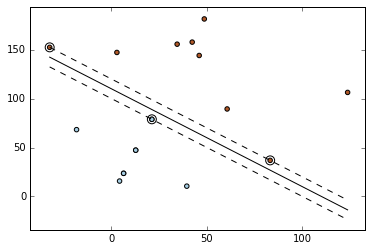

prime sv:  [ 21.13248654  78.86751346]

SVM Set 1: LEFT


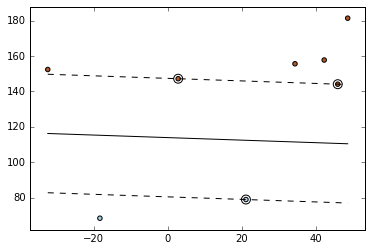


SVM Set 2: RIGHT


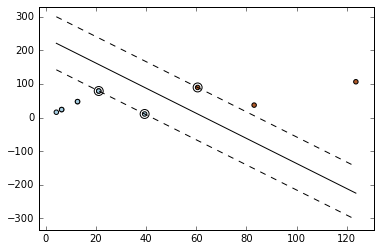

Folding 1 . Folding the left. Margin: 40.824829


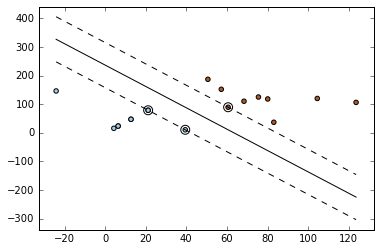

v:  [ 83.09401077  36.90598923 -57.73502692]  u:  [ 60.56624327  89.43375673  46.18802154]
w:  [  22.5277675   -52.5277675  -103.92304845]
W:  118.602979164
W12:  57.1547606649
X initial points: 

            f1          f2          f3
0   -24.237191  146.309945   57.735027
1    50.595985  187.134723 -115.470054
2    80.096754  118.361875   -5.773503
3    75.517885  125.122098  -17.320508
4    68.387703  110.431041    0.000000
5    57.202409  152.162994  -51.961524
6   104.528634  120.117789   17.320508
7    21.132487   78.867513  -28.867513
8    21.132487   78.867513    0.000000
9     4.226497   15.773503   -5.773503
10    6.339746   23.660254  -63.508530
11    6.339746   23.660254  -57.735027
12   12.679492   47.320508  -51.961524
13   12.679492   47.320508  -57.735027
14   39.433757   10.566243  -28.867513
15   83.094011   36.905989  -57.735027
16   60.566243   89.433757   46.188022
17  123.660254  106.339746 -103.923048

X Projected points: 

            f1          f2          f3


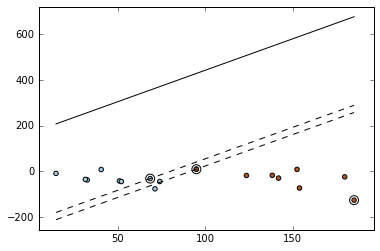

TypeError: 'NoneType' object has no attribute '__getitem__'

In [224]:
########################################
####             MAIN               ####
#### 30th June 2017                 ####
#### 3D case for hyperplane folding ####
#### 1. Projecting                  ####
#### 2. 2D case                     ####
########################################


# Import necessary packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math
import pandas as pd
from sklearn import datasets
from random import randint
from matplotlib.backends.backend_pdf import PdfPages
import time
from pylab import *

def main():
    iterations=2
    
    # Dataset
    dataset = load_dataset('toy_dataset.csv')
    Y = dataset['class']

    # Project the points
    X_projected, Z = project_points(dataset)
   
    # Training 2D
    training(X_projected, Y, Z, iterations)

    # Testing 2D
    testing(dataset)

    
if __name__ =='__main__':
    main()

In [222]:
# clf = get_clf() 
# clf.fit(d_x, d_y)
# Mismatch between support_vectors and dual coef
clf = get_clf() 
clf.fit(d_x, d_y)
clf.support_vectors_ = clf.support_vectors_[0:2]
clf.dual_coef_ = clf.dual_coef_[0,0:2]
clf.dual_coef_ = clf.dual_coef_.reshape((1,-1))

# print a.reshape((1, -1))
# print clf.dual_coef_
print clf.coef_[0]
print clf.support_
# print clf.n_support_
print clf.support_vectors_


# x[[[1],[3]],[1,3]]
# print len(clf.support_vectors_)

[-0.35683969 -0.10293176]
[ 1  9 10]
[[  21.13248654   78.86751346]
 [ -32.37604307  152.37604307]]
